In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')


forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [3]:
# aoi
from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee(forestry.config["AOI_path"])

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

✅ AOI loaded: 1 features
   Area: 144217.67 hectares


In [4]:
import pandas as pd

use_existing_parquet_features = True
feature_path = forestry.config["tsfresh_feature_path"]

x_features = pd.read_parquet(feature_path, filesystem=fs)
x_features.head()

,plot_id,pixel_idx,x_coord,y_coord,FCD__minimum,FCD__quantile__q_0.1,FCD__quantile__q_0.2,FCD__quantile__q_0.3,FCD__variation_coefficient,FCD__ar_coefficient__coeff_1__k_10,...,FCD__spkt_welch_density__coeff_5,FCD__mean,FCD__partial_autocorrelation__lag_3,FCD__number_cwt_peaks__n_1,FCD__first_location_of_maximum,FCD__cid_ce__normalize_False,"FCD__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","FCD__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","FCD__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""",target
0,sample_2,0,591279.536409,9.951896e+06,40.310783,53.765110,54.630764,54.821644,0.159008,0.0,...,95.939644,62.548325,-0.117712,2.0,0.818182,31.986671,39.700375,0.0,0.0,1.0
1,sample_2,1,591289.536409,9.951896e+06,42.398647,53.366261,54.090191,57.101311,0.136280,0.0,...,83.064148,61.331608,-0.264524,2.0,0.818182,28.960953,42.256060,0.0,0.0,1.0
2,sample_2,2,591299.536409,9.951896e+06,44.369419,56.416084,56.896336,59.636372,0.130409,0.0,...,98.866089,63.696568,-0.251399,2.0,0.818182,29.286819,44.061781,0.0,0.0,1.0
3,sample_2,3,591309.536409,9.951896e+06,40.895134,54.373569,57.268482,58.583836,0.151164,0.0,...,117.564041,62.185108,-0.304967,2.0,0.545455,30.412758,41.378662,0.0,0.0,1.0
4,sample_2,4,591319.536409,9.951896e+06,39.762424,54.452785,55.818935,55.962696,0.157619,0.0,...,102.588135,61.608410,-0.271590,2.0,0.545455,30.509115,41.027517,0.0,0.0,1.0


In [5]:
# x_features.columns

In [6]:
# x_features.values

In [7]:
import numpy as np
import xarray as xr

# Define column names for metadata
col_plot_id = 'plot_id'
col_index = 'pixel_idx'
col_y = 'target'
col_coord_x = 'x_coord'
col_coord_y = 'y_coord'

# Extract metadata columns (these should be excluded from features)
metadata_cols = [col_plot_id, col_index, col_y, col_coord_x, col_coord_y]
# Filter out any metadata columns that don't exist in x_features
metadata_cols = [col for col in metadata_cols if col in x_features.columns]

# Extract feature columns (all columns except metadata)
feature_cols = [col for col in x_features.columns if col not in metadata_cols]

# Extract feature matrix (X_train)
X_train = x_features[feature_cols].values

# Extract target (y_train)
y_train = x_features[col_y].values if col_y in x_features.columns else None

# Extract plot IDs
plot_train = x_features[col_plot_id].values if col_plot_id in x_features.columns else None

# Extract coordinates
cords_x_train = x_features[col_coord_x].values if col_coord_x in x_features.columns else None
cords_y_train = x_features[col_coord_y].values if col_coord_y in x_features.columns else None

# Get dimensions
n_samples, n_features = X_train.shape

# Create an xarray.Dataset holding the training arrays
ds_train = xr.Dataset(
    {
        "X_features": (("sample", "features"), X_train), #features
        "y": (("sample",), y_train), # target
        "plot_id": (("sample",), plot_train), # plot id
        "coord_x": (("sample",), cords_x_train), # x coordinate
        "coord_y": (("sample",), cords_y_train) # y coordinate
    },
    coords={
        "sample": np.arange(n_samples),
        "features": feature_cols  # Use feature column names as coordinates
    }
)

print(f"✅ Created ds_train with {n_samples} samples and {n_features} features")
print(f"   Variables: {list(ds_train.data_vars)}")
print(f"   Dimensions: {dict(ds_train.sizes)}")

✅ Created ds_train with 132576 samples and 50 features
   Variables: ['X_features', 'y', 'plot_id', 'coord_x', 'coord_y']
   Dimensions: {'sample': 132576, 'features': 50}


In [8]:
ds_train

<xarray.Dataset> Size: 58MB
Dimensions:     (sample: 132576, features: 50)
Coordinates:
  * sample      (sample) int64 1MB 0 1 2 3 4 ... 132572 132573 132574 132575
  * features    (features) <U67 13kB 'FCD__minimum' ... 'FCD__agg_linear_tren...
Data variables:
    X_features  (sample, features) float64 53MB 40.31 53.77 54.63 ... 0.0 0.0
    y           (sample) float32 530kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    plot_id     (sample) object 1MB 'sample_2' 'sample_2' ... 'sample_1'
    coord_x     (sample) float64 1MB 5.913e+05 5.913e+05 ... 5.894e+05 5.894e+05
    coord_y     (sample) float64 1MB 9.952e+06 9.952e+06 ... 9.954e+06 9.954e+06

In [9]:
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr
import os

In [10]:
## TO DO TO SEARCH dvc - later we can improve, now we still have issues with dvc imported from aws to gcs
# import os

# # Load ds_train from DVC zarr using DVC's standard cache path format
# # DVC output: md5: d045be4b79be2f7a4c977a2387e212ea.dir, path: ds_train.zarr
# # DVC standard format: md5/<first2chars>/<rest_of_hash>/<original_path>
# dvc_hash = "d045be4b79be2f7a4c977a2387e212ea"  # From DVC output (remove .dir)
# dvc_path = "ds_train.zarr"  # Path in DVC

# # Get DVC remote config (GCS)
# remote_url = os.getenv('GCS_BACKUP')
# if not remote_url.startswith('gs://'):
#     remote_url = f"gs://{remote_url}"

# # Construct DVC cache path using DVC's standard format
# # DVC splits hash: first 2 chars as subdirectory, rest as directory name
# cache_path = f"{dvc_hash[:2]}/{dvc_hash[2:]}"
# zarr_path = f"{remote_url}/md5/{cache_path}/{dvc_path}"

# # Load zarr dataset
# example_ds_train = load_dataset_zarr(zarr_path, storage='gcs')
# print(f"✅ Loaded: {dict(example_ds_train.sizes)}, vars: {list(example_ds_train.data_vars)}")


In [11]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from catboost import CatBoostClassifier
import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import xarray as xr
import os
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
from skimage.morphology import remove_small_objects
from scipy.ndimage import generic_filter
from sklearn.metrics import accuracy_score, classification_report
from multiprocessing import Pool
import json
from progiter import ProgIter
import hashlib
from skimage.segmentation import clear_border

Found 3 unique plots: ['sample_1' 'sample_2' 'sample_3']


0:	learn: 0.6866394	test: 0.6869885	best: 0.6869885 (0)	total: 17.2ms	remaining: 17.2s
100:	learn: 0.4187289	test: 0.4377188	best: 0.4377188 (100)	total: 1.7s	remaining: 15.1s
200:	learn: 0.3777309	test: 0.3981594	best: 0.3981594 (200)	total: 3.29s	remaining: 13.1s
300:	learn: 0.3653386	test: 0.3902575	best: 0.3894554 (287)	total: 4.86s	remaining: 11.3s
400:	learn: 0.3584894	test: 0.3911735	best: 0.3892329 (312)	total: 6.37s	remaining: 9.52s
500:	learn: 0.3536194	test: 0.3957433	best: 0.3892329 (312)	total: 7.94s	remaining: 7.91s
600:	learn: 0.3499004	test: 0.4011306	best: 0.3892329 (312)	total: 9.52s	remaining: 6.32s
700:	learn: 0.3467024	test: 0.4047155	best: 0.3892329 (312)	total: 11s	remaining: 4.71s
800:	learn: 0.3440958	test: 0.4080181	best: 0.3892329 (312)	total: 12.5s	remaining: 3.11s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3892329437
bestIteration = 312

Shrink model to first 313 iterations.
Trained model for plot: sample_1
0:	learn: 0.6868755	test

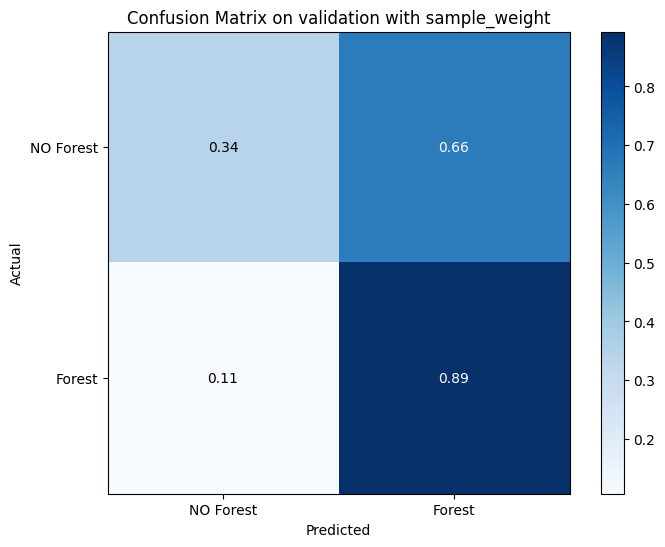

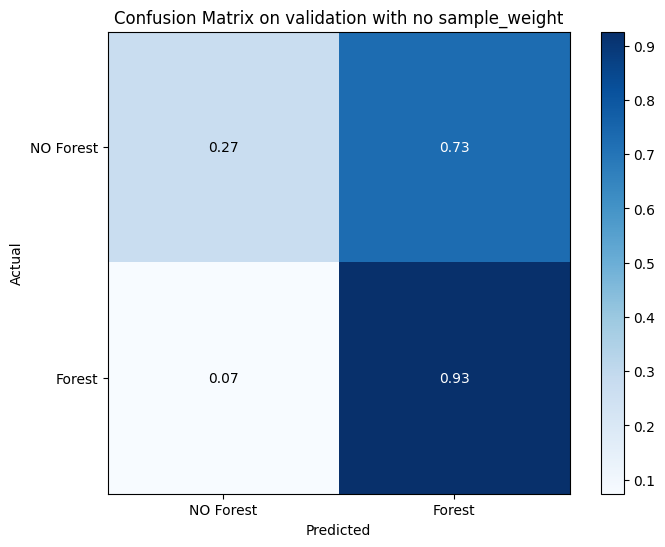

In [21]:
import numpy as np

## train leave one out
def calculate_sample_weight(ds):
    # Sample weights based on number of pixels per plot in ds
    all_plot_ids = ds['plot_id'].values
    unique_plots, counts = np.unique(all_plot_ids, return_counts=True)
    plot_counts = dict(zip(unique_plots, counts))
    sample_weight = np.array([1.0 / plot_counts[pid] for pid in all_plot_ids])
    ds['sample_weight'] = ('sample', sample_weight)
    return ds

def prepare_config(model_config, plot_ids, input_config=dict(), use_proba=False, optimal_threshold=0.5):
    """
    Prepare configuration with unique hash based on model settings and threshold
    
    Parameters:
    -----------
    use_proba : bool
        Whether using probability-based predictions (affects hash)
    optimal_threshold : float
        Threshold value (affects hash to ensure different configs get different cache)
    """
    # Convert numpy array to list for JSON serialization
    if isinstance(plot_ids, np.ndarray):
        plot_ids_list = plot_ids.tolist()
    else:
        plot_ids_list = list(plot_ids)
    
    config = {'model': model_config, 'plots': plot_ids_list, 'sample_weight': True}
    # merge config with input_config
    config.update(input_config)
    
    # Add threshold info to config for tracking
    config['use_proba'] = use_proba
    config['optimal_threshold'] = optimal_threshold
    
    # Create a copy of config for hashing (without verbose for consistency)
    config_for_hash = config.copy()
    if 'verbose' in config_for_hash['model']:
        config_for_hash['model'] = config_for_hash['model'].copy()
        del config_for_hash['model']['verbose']
    
    # Include threshold and use_proba in hash to ensure different configs get different cache
    config_for_hash['hash_meta'] = {
        'use_proba': use_proba,
        'optimal_threshold': optimal_threshold
    }
    
    config['hash'] = hashlib.md5(json.dumps(config_for_hash, sort_keys=True).encode('utf-8')).hexdigest()
    
    if 'verbose' in config['model']:
        del config['model']['verbose']
    
    # create cache directory if it does not exist
    if not os.path.exists(f"/mnt/data/cache/{config['hash']}"):
        os.makedirs(f"/mnt/data/cache/{config['hash']}", exist_ok=True)
        json.dump(config, open(f"/mnt/data/cache/{config['hash']}/config.json", 'w'))

    return config

def load_dataset(ds, val_plot_id=None, all_data=False):
    """Split dataset into train and validation sets based on plot_id"""
    ds = calculate_sample_weight(ds)

    # Extract unique plot IDs
    plot_ids = np.unique(ds['plot_id'].values)

    if all_data:
        train_plots = plot_ids
        val_plots = plot_ids
    elif val_plot_id is not None:
        # Use specified plot for validation
        train_plots = np.setdiff1d(plot_ids, [val_plot_id])
        val_plots = np.array([val_plot_id])
    else:
        # Randomly select one plot for validation
        np.random.seed(43)
        val_plot_id = np.random.choice(plot_ids, size=1)[0]
        train_plots = np.setdiff1d(plot_ids, [val_plot_id])
        val_plots = np.array([val_plot_id])

    # Subset the dataset by sample dimension using plot_id variable
    mask_train = ds['plot_id'].isin(train_plots)
    ds_train = ds.where(mask_train, drop=True)
    mask_val = ds['plot_id'].isin(val_plots)
    ds_val = ds.where(mask_val, drop=True)
    
    return ds_train, ds_val

def train(ds_train, ds_val, config, plot_id=""):    
    # https://catboost.ai/docs/en/references/training-parameters/common
    # Use X_features (not X_features_mediun) - matches our ds_train structure
    X_train_features = ds_train.X_features.values
    X_val_features = ds_val.X_features.values
    y_train = ds_train.y.values
    y_val = ds_val.y.values
    sample_weight_train = ds_train.sample_weight.values
    sample_weight_val = ds_val.sample_weight.values

    catboost_model = CatBoostClassifier(**config['model'])

    sample_weight = sample_weight_train if config['sample_weight'] else None
    catboost_model.fit(
        X_train_features, y_train, 
        eval_set=(X_val_features, y_val), 
        sample_weight=sample_weight, 
        verbose=config['model'].get('verbose', 100)
    )
    
    model_path = f"/mnt/data/cache/{config['hash']}/catboost_plot_{plot_id}.cbm"
    catboost_model.save_model(model_path)

    return catboost_model

def save_predictions(results, config):
    # save results - fix np.concat to np.concatenate
    y_train_pred = np.concatenate([r['y_train_pred'].values for r in results])
    y_train = np.concatenate([r['y_train'].values for r in results])
    y_test_pred = np.concatenate([r['y_test_pred'].values for r in results])
    y_test = np.concatenate([r['y_test'].values for r in results])
    sample_weight_train = np.concatenate([r['train_sample_weight'].values for r in results])
    sample_weight_val = np.concatenate([r['test_sample_weight'].values for r in results])

    # save numpy arrays to disk
    cache_dir = f"/mnt/data/cache/{config['hash']}"
    os.makedirs(cache_dir, exist_ok=True)
    np.savez_compressed(f"{cache_dir}/predictions.npz",
        y_train_pred=y_train_pred,
        y_train=y_train,
        y_test_pred=y_test_pred,
        y_test=y_test,
        sample_weight_train=sample_weight_train,
        sample_weight_val=sample_weight_val
    )

# train leave one out
def load_predictions(config):
    # load predictions
    data = np.load(f"/mnt/data/cache/{config['hash']}/predictions.npz")
    y_train_pred = data['y_train_pred']
    y_train = data['y_train']
    y_test_pred = data['y_test_pred']
    y_test = data['y_test']
    sample_weight_train = data['sample_weight_train']
    sample_weight_val = data['sample_weight_val']
    
    return y_train_pred, y_train, y_test_pred, y_test, sample_weight_train, sample_weight_val

def _process_plot(plot_id, ds_full, config, all_data=False, use_proba=False, optimal_threshold=0.5):
    """
    Process a single plot for leave-one-out cross-validation
    
    Parameters:
    -----------
    use_proba : bool
        If True, use train_with_proba to get probabilities and apply threshold optimization
    optimal_threshold : float
        Threshold to use when use_proba=True (default 0.5)
    """
    ds_train, ds_val = load_dataset(ds_full, val_plot_id=plot_id, all_data=all_data)
    
    if use_proba:
        # Use probability-based training for threshold optimization
        model, y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_with_proba(
            ds_train, ds_val, config=config, plot_id=plot_id
        )
        # Apply optimal threshold to validation predictions
        y_test_pred = (y_test_proba >= optimal_threshold).astype(int)
        print(f"Trained model for plot: {plot_id} (threshold: {optimal_threshold:.3f})")
    else:
        # Standard training (faster, but no threshold optimization)
        model = train(ds_train, ds_val, config=config, plot_id=plot_id)
        y_train_pred = model.predict(ds_train.X_features.values)
        y_test_pred = model.predict(ds_val.X_features.values)
        print(f"Trained model for plot: {plot_id}")
    
    # Return as xarray Dataset so save_predictions can access .values
    # Use different dimension names for train and validation since they have different sizes
    return xr.Dataset({
        "y_train_pred":      (("train_sample",), y_train_pred),
        "y_train":           (("train_sample",), ds_train.y.values),
        "y_test_pred":       (("val_sample",), y_test_pred),
        "y_test":            (("val_sample",), ds_val.y.values),
        "train_sample_weight": (("train_sample",), ds_train.sample_weight.values),
        "test_sample_weight":  (("val_sample",), ds_val.sample_weight.values)
    })


def train_leave_one_out(ds_full, config, plot_ids, all_data=False, use_proba=False, optimal_threshold=0.5, force_retrain=False):
    """
    Train models using leave-one-plot-out cross-validation
    
    Parameters:
    -----------
    use_proba : bool
        If True, use probability predictions and apply threshold optimization
    optimal_threshold : float
        Threshold to use when use_proba=True (default 0.5)
    force_retrain : bool
        If True, force retraining even if predictions exist (default False)
    """
    predictions_path = f"/mnt/data/cache/{config['hash']}/predictions.npz"
    if os.path.exists(predictions_path) and not force_retrain:
        print(f"Predictions already exist at {predictions_path}")
        print(f"   Hash: {config['hash']}")
        print(f"   Use force_retrain=True to retrain, or use a different config/threshold")
        return   
    
    results = []
    # Process each plot sequentially (can be parallelized if needed)
    for plot_id in plot_ids:
        result = _process_plot(plot_id, ds_full, config, all_data=all_data, 
                              use_proba=use_proba, optimal_threshold=optimal_threshold)
        results.append(result)
    
    # Alternative: parallel processing (uncomment if needed)
    # with Pool(processes=min(len(plot_ids), os.cpu_count())) as pool:
    #     results = pool.starmap(_process_plot, [(pid, ds_full, config, all_data, use_proba, optimal_threshold) for pid in plot_ids])
    
    save_predictions(results, config)   


## model preparation - config
# Get plot IDs from ds_train
plot_ids = np.unique(ds_train['plot_id'].values)
print(f"Found {len(plot_ids)} unique plots: {plot_ids[:10]}..." if len(plot_ids) > 10 else f"Found {len(plot_ids)} unique plots: {plot_ids}")

model_config = dict(
    iterations=1000,
    learning_rate=0.01,
    eval_metric='Logloss',
    #eval_metric='Recall',
    # eval_metric='Precision',
    # eval_metric='AUC',
    l2_leaf_reg=6, # default is 3
    random_seed=42,
    early_stopping_rounds=500,
    verbose=100,
    # verbose=0,
    use_best_model=True,
    depth=2,
    # auto_class_weights='Balanced')
    class_weights=[1.0, 3.0]
)

# Prepare config with plot_ids
config = prepare_config(model_config, plot_ids, {'sample_weight': False})

# Train with leave-one-plot-out cross-validation
# Use a subset of plots for testing (comment out to use all plots)
# plot_ids_subset = plot_ids[:3]  # Use first 3 plots for testing
# train_leave_one_out(ds_train, config, plot_ids_subset)

# Or use all plots
train_leave_one_out(ds_train, config, plot_ids)

"""
# Example: prepare runs with different l2_leaf_reg values
for i in [3, 6, 9]:
    model_config['l2_leaf_reg'] = i
    config = prepare_config(model_config, plot_ids)
    train_leave_one_out(ds_train, config, plot_ids)

    y_train_pred, y_train, y_test_pred, y_test, sample_weight_train, sample_weight_val = load_predictions(config)
    plot_confusion_matrix(y_test, y_test_pred, sample_weight=sample_weight_val, dataset="validation")
    plot_confusion_matrix(y_test, y_test_pred, dataset="validation")
"""


def remove_small_objects_eligibility(da, min_size, mode_filter_size):
    """
    For each season slice in da (dims: season, y, x), remove connected
    components smaller than `min_size` and then apply a mode filter of
    size `mode_filter_size`. Returns a new DataArray named <original>_cleaned.
    """
    def mode_filter(values):
        vals = values.astype(int)
        return np.bincount(vals).argmax()

    # original nan‐mask
    nan_mask = np.isnan(da.values)
    # boolean array for morphology
    arr = da.values.astype(bool)
    # replace NaNs with median
    arr[np.isnan(arr)] = np.nanmedian(arr)
    cleaned = np.zeros_like(arr, dtype=bool)

    cleaned = generic_filter(
        arr,
        function=mode_filter,
        size=mode_filter_size,
        mode='nearest'
    )
    # process each season slice
    cleaned = remove_small_objects(cleaned, min_size=min_size)
    # build output DataArray
    cleaned_float = cleaned.astype(float)
    # reintroduce NaNs
    cleaned_float[nan_mask] = np.nan

    return xr.DataArray(
        cleaned_float,
        coords=da.coords,
        dims=da.dims,
        name=f"{da.name}_cleaned"
    )
    
def plot_confusion_matrix(y_val, y_var_pred, class_names=['NO Forest', 'Forest'], sample_weight=None, dataset="training"):
    cm = confusion_matrix(y_val, y_var_pred, normalize='true', sample_weight=sample_weight)
    # plot confusion matrix
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='white' if cm[i, j] > 0.5 else 'black')
    # add TP, FP, TN, FN labels
    plt.xticks(ticks=range(cm.shape[1]), labels=class_names)
    plt.yticks(ticks=range(cm.shape[0]), labels=class_names)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix on {dataset} with {"sample_weight" if sample_weight is not None else "no sample_weight"}')
    plt.show()

def plot_roc_curve(X_features, y, model):
    # Compute predicted probabilities for the positive class
    y_scores = model.predict_proba(X_features)[:, 1]
    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    # Compute area under the ROC curve
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_classification_report(y_true, y_pred, class_names=None, figsize=(8, 6), cmap='Blues', sample_weight=None):
    """
    Plots a heatmap of precision, recall and f1-score from a classification_report.
    y_true: array-like of true labels
    y_pred: array-like of predicted labels
    class_names: list of class names in the order of label encoding
    """
    from sklearn.metrics import classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd

    # compute report
    report_dict = classification_report(y_true, y_pred,
                                        target_names=class_names,
                                        output_dict=True,
                                        sample_weight=sample_weight)
    report_df = pd.DataFrame(report_dict).T
    # drop the accuracy row and support column
    report_df = report_df.iloc[:-3, :-1]

    plt.figure(figsize=figsize)
    sns.heatmap(report_df.astype(float),
                annot=True,
                cmap=cmap,
                cbar=False,
                fmt=".2f")
    plt.title('Classification Report')
    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.yticks(rotation=0)
    plt.show()

def plot_roc_curve2(X_features, y, model):
    # Compute predicted probabilities for the positive class
    y_scores = model.predict_proba(X_features)[:, 1]

    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve')
    # fill area under the ROC curve
    plt.fill_between(fpr, tpr, color='blue', alpha=0.2, 
                     label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')

    # Annotate thresholds every Nth point
    step = max(1, len(thresholds) // 20)
    for idx in range(0, len(thresholds), step):
        plt.text(fpr[idx], tpr[idx], f"{thresholds[idx]:.2f}",
                 fontsize=8, ha='center', va='bottom', color='red')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)

# confusion matrix
y_train_pred, y_train, y_test_pred, y_test, sample_weight_train, sample_weight_val = load_predictions(config)

# plot_confusion_matrix(y_train, y_train_pred, sample_weight=sample_weight_train, dataset="training")
# plot_confusion_matrix(y_train, y_train_pred, dataset="training")
plot_confusion_matrix(y_test, y_test_pred, sample_weight=sample_weight_val, dataset="validation")
plot_confusion_matrix(y_test, y_test_pred, dataset="validation")


📊 Analyzing class distribution in ds_train...
CLASS DISTRIBUTION ANALYSIS
Class 0.0: 55,740 samples (42.04%)
Class 1.0: 76,836 samples (57.96%)
Total: 132,576 samples
Imbalance ratio: 1.38:1
OPTIMAL CLASS WEIGHTS (balanced)
Class 0.0: 1.1892
Class 1.0: 0.8627


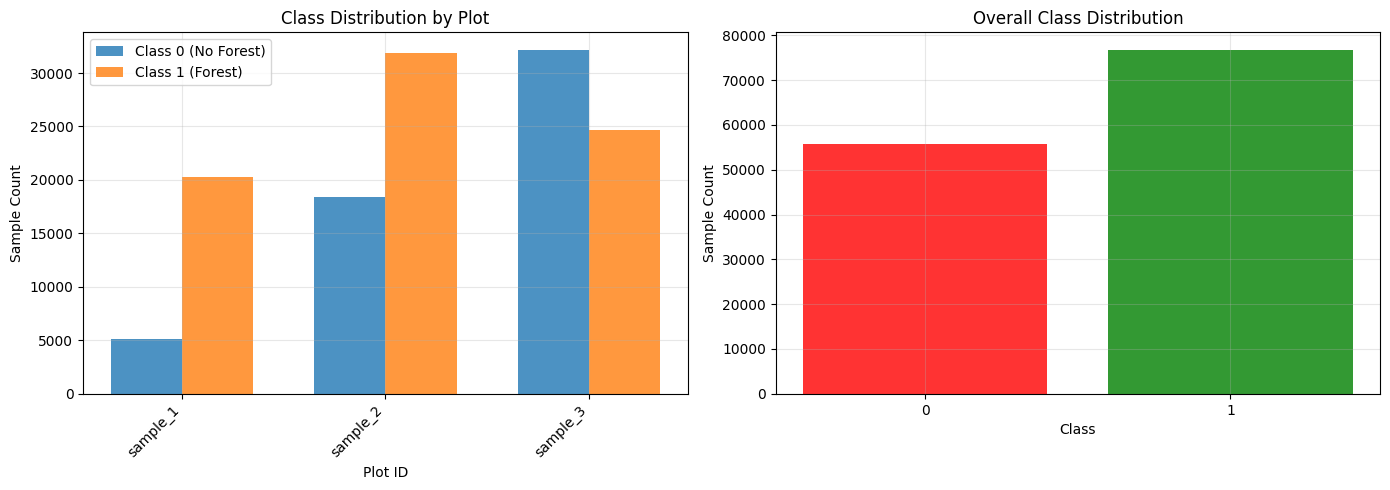

In [22]:
# ============================================================================
# IMPROVING MODEL ACCURACY - Recommendations and Analysis Tools
# ============================================================================

def analyze_class_distribution(ds):
    """Analyze class distribution in the dataset"""
    y = ds.y.values
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    
    print("=" * 60)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("=" * 60)
    for cls, count in zip(unique, counts):
        pct = (count / total) * 100
        print(f"Class {cls}: {count:,} samples ({pct:.2f}%)")
    print(f"Total: {total:,} samples")
    print(f"Imbalance ratio: {max(counts) / min(counts):.2f}:1")
    print("=" * 60)
    
    return unique, counts

def calculate_optimal_class_weights(y):
    """Calculate balanced class weights using sklearn's compute_class_weight"""
    from sklearn.utils.class_weight import compute_class_weight
    
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes=classes, y=y)
    weight_dict = dict(zip(classes, weights))
    
    print("=" * 60)
    print("OPTIMAL CLASS WEIGHTS (balanced)")
    print("=" * 60)
    for cls, weight in weight_dict.items():
        print(f"Class {cls}: {weight:.4f}")
    print("=" * 60)
    
    # Return as list for CatBoost (assuming binary classification: [class_0_weight, class_1_weight])
    if len(classes) == 2:
        return [weight_dict[0], weight_dict[1]]
    return list(weights)

def plot_class_distribution_by_plot(ds):
    """Visualize class distribution across different plots"""
    import matplotlib.pyplot as plt
    
    plot_ids = ds.plot_id.values
    y = ds.y.values
    
    unique_plots = np.unique(plot_ids)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count by plot
    plot_class_counts = {}
    for plot_id in unique_plots:
        mask = plot_ids == plot_id
        unique, counts = np.unique(y[mask], return_counts=True)
        plot_class_counts[plot_id] = dict(zip(unique, counts))
    
    # Plot 1: Class distribution per plot
    plot_ids_sorted = sorted(unique_plots)
    class_0_counts = [plot_class_counts[p].get(0, 0) for p in plot_ids_sorted]
    class_1_counts = [plot_class_counts[p].get(1, 0) for p in plot_ids_sorted]
    
    x = np.arange(len(plot_ids_sorted))
    width = 0.35
    axes[0].bar(x - width/2, class_0_counts, width, label='Class 0 (No Forest)', alpha=0.8)
    axes[0].bar(x + width/2, class_1_counts, width, label='Class 1 (Forest)', alpha=0.8)
    axes[0].set_xlabel('Plot ID')
    axes[0].set_ylabel('Sample Count')
    axes[0].set_title('Class Distribution by Plot')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(plot_ids_sorted, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Overall class distribution
    unique, counts = np.unique(y, return_counts=True)
    axes[1].bar(unique, counts, alpha=0.8, color=['red', 'green'])
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Sample Count')
    axes[1].set_title('Overall Class Distribution')
    axes[1].set_xticks(unique)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analyze current dataset
print("\n📊 Analyzing class distribution in ds_train...")
unique_classes, class_counts = analyze_class_distribution(ds_train)

# Calculate optimal class weights
optimal_weights = calculate_optimal_class_weights(ds_train.y.values)

# Visualize distribution
plot_class_distribution_by_plot(ds_train)


# 🎯 Recommendations to Improve "No Forest" Class Accuracy (0.34 → target: >0.70)

## Current Issue Analysis
- **Forest class**: 0.89 accuracy ✅ (good)
- **No Forest class**: 0.34 accuracy ❌ (poor)
- This indicates **severe class imbalance** where the model is biased toward the majority class

## Recommended Solutions (in order of impact):

### 1. **Class Weight Adjustment** ⭐⭐⭐ (HIGHEST IMPACT)
   - Current: `class_weights=[1.0, 3.0]` (gives 3x weight to Forest)
   - **Problem**: If "No Forest" is the minority class, it needs MORE weight, not less
   - **Solution**: Use calculated balanced weights or increase weight for minority class
   - **Action**: Run the analysis cell above to get optimal weights

### 2. **Enable Sample Weights** ⭐⭐⭐ (HIGH IMPACT)
   - Currently: `sample_weight=False` in config
   - **Solution**: Set `sample_weight=True` to balance plot-level representation
   - This helps when some plots have many more samples than others

### 3. **Feature Engineering - Additional Spectral Indices** ⭐⭐ (MEDIUM-HIGH IMPACT)
   - **Current**: Using tsfresh features from time series
   - **Add these spectral indices** (if not already included):
     - **NDVI** (Normalized Difference Vegetation Index)
     - **EVI** (Enhanced Vegetation Index) 
     - **NDMI** (Normalized Difference Moisture Index)
     - **SAVI** (Soil-Adjusted Vegetation Index)
     - **BSI** (Bare Soil Index)
     - **NDBI** (Normalized Difference Built-up Index)
   - **Why**: Different indices capture different aspects (vegetation, moisture, soil) that help distinguish forest vs non-forest

### 4. **Model Hyperparameter Tuning** ⭐⭐ (MEDIUM IMPACT)
   - Increase model complexity: `depth=4-6` (currently 2)
   - Adjust `l2_leaf_reg` (regularization): try [3, 6, 9, 12]
   - Increase `iterations` if needed
   - Use `auto_class_weights='Balanced'` instead of manual weights

### 5. **Data Balancing Techniques** ⭐ (LOW-MEDIUM IMPACT)
   - **SMOTE** (Synthetic Minority Oversampling) - if you have enough memory
   - **Undersampling** majority class (loses data)
   - **Stratified sampling** when splitting train/val

### 6. **Increasing Sample Size** ⭐ (LOW IMPACT - if already have enough)
   - **Only helps if**: You have <10k samples per class
   - **Your case**: Likely already have enough samples (132k+ total)
   - **Better approach**: Focus on quality and balance, not just quantity

## Quick Win Strategy:
1. **First**: Fix class weights (use balanced weights from analysis)
2. **Second**: Enable sample_weight=True
3. **Third**: Add more spectral indices to feature extraction
4. **Fourth**: Tune hyperparameters


In [23]:
# ============================================================================
# ADVANCED TECHNIQUES TO REACH 0.8+ ACCURACY FOR BOTH CLASSES
# ============================================================================

def find_optimal_threshold(y_true, y_proba, metric='f1'):
    """
    Find optimal classification threshold using ROC curve
    This helps balance precision/recall for both classes
    """
    from sklearn.metrics import f1_score, precision_recall_curve, roc_curve
    
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    
    # Calculate F1 score for each threshold
    f1_scores = []
    for threshold in thresholds:
        y_pred_thresh = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred_thresh, average='weighted')
        f1_scores.append(f1)
    
    # Find threshold with best F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold, thresholds, f1_scores

def evaluate_with_threshold(y_true, y_proba, threshold=0.5):
    """Evaluate predictions with custom threshold"""
    y_pred = (y_proba >= threshold).astype(int)
    from sklearn.metrics import confusion_matrix, classification_report
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    report = classification_report(y_true, y_pred, output_dict=True)
    
    return y_pred, cm, report

def plot_threshold_analysis(y_true, y_proba):
    """Visualize how different thresholds affect class accuracy"""
    import matplotlib.pyplot as plt
    
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    optimal_threshold, all_thresholds, f1_scores = find_optimal_threshold(y_true, y_proba)
    
    # Calculate accuracy for each class at different thresholds
    class_0_acc = []  # NO Forrest
    class_1_acc = []  # Forrest
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        if cm.shape == (2, 2):
            class_0_acc.append(cm[0, 0])  # True negative rate
            class_1_acc.append(cm[1, 1])  # True positive rate
        else:
            class_0_acc.append(0)
            class_1_acc.append(0)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Class accuracy vs threshold
    axes[0].plot(thresholds, class_0_acc, label='NO Forrest Accuracy', linewidth=2)
    axes[0].plot(thresholds, class_1_acc, label='Forrest Accuracy', linewidth=2)
    axes[0].axhline(y=0.8, color='r', linestyle='--', label='Target (0.8)', alpha=0.7)
    axes[0].axvline(x=optimal_threshold, color='g', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})', alpha=0.7)
    axes[0].set_xlabel('Classification Threshold')
    axes[0].set_ylabel('Class Accuracy')
    axes[0].set_title('Class Accuracy vs Classification Threshold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: F1 score vs threshold
    axes[1].plot(thresholds, f1_scores, label='Weighted F1 Score', linewidth=2, color='purple')
    axes[1].axvline(x=optimal_threshold, color='g', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})', alpha=0.7)
    axes[1].set_xlabel('Classification Threshold')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title('F1 Score vs Classification Threshold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return optimal_threshold

print("✅ Threshold optimization functions created!")
print("💡 Use these to find optimal decision threshold for balanced performance")


✅ Threshold optimization functions created!
💡 Use these to find optimal decision threshold for balanced performance


In [24]:
# ============================================================================
# IMPROVED MODEL CONFIGURATIONS FOR 0.8+ TARGET
# ============================================================================

# Configuration 1: Focus on balanced performance with threshold tuning
model_config_balanced_advanced = dict(
    iterations=2000,  # More iterations for better learning
    learning_rate=0.005,  # Lower learning rate for fine-tuning
    eval_metric='F1',  # Use F1 instead of Logloss for balanced classes
    l2_leaf_reg=3,  # Less regularization to allow more complexity
    random_seed=42,
    early_stopping_rounds=300,
    verbose=100,
    use_best_model=True,
    depth=6,  # Deeper trees to capture complex patterns
    auto_class_weights='Balanced',
    min_data_in_leaf=5,  # Allow smaller leaves for minority class
    max_leaves=128,  # More leaves for complex decision boundaries
    grow_policy='Lossguide',  # Better for imbalanced data
    bootstrap_type='Bayesian',  # Better uncertainty estimation
    bagging_temperature=1.0,
    random_strength=1.0,
    # Focus on both classes equally
    class_weights=None,  # Will use auto_class_weights instead
)

# Configuration 2: Aggressive weighting for minority class
# Use this if NO Forrest is still underperforming
model_config_aggressive_weights = dict(
    iterations=2000,
    learning_rate=0.005,
    eval_metric='F1',
    l2_leaf_reg=3,
    random_seed=42,
    early_stopping_rounds=300,
    verbose=100,
    use_best_model=True,
    depth=6,
    # Aggressive weights - adjust based on your class distribution
    # If NO Forrest (class 0) is minority: [10.0, 1.0]
    # If Forrest (class 1) is minority: [1.0, 10.0]
    class_weights=[10.0, 1.0],  # 10x weight for class 0 (NO Forrest)
    min_data_in_leaf=3,  # Even smaller leaves
    max_leaves=256,
    grow_policy='Lossguide',
    bootstrap_type='Bayesian',
    bagging_temperature=0.8,
    random_strength=0.8,
)

# Configuration 3: Ensemble-ready configuration
model_config_ensemble = dict(
    iterations=1500,
    learning_rate=0.01,
    eval_metric='F1',
    l2_leaf_reg=6,
    random_seed=42,  # Change seed for each model in ensemble
    early_stopping_rounds=300,
    verbose=100,
    use_best_model=True,
    depth=5,
    auto_class_weights='Balanced',
    min_data_in_leaf=10,
    max_leaves=64,
    grow_policy='SymmetricTree',
    bootstrap_type='Bernoulli',
    subsample=0.8,  # Use 80% of data for each tree
)

print("✅ Advanced model configurations created!")
print("\n📊 Recommended approach to reach 0.8+ for both classes:")
print("   1. Use model_config_balanced_advanced with eval_metric='F1'")
print("   2. Train model and get probability predictions")
print("   3. Use threshold optimization to find best decision threshold")
print("   4. If still not 0.8+, try model_config_aggressive_weights")
print("   5. Consider ensemble of multiple models")


✅ Advanced model configurations created!

📊 Recommended approach to reach 0.8+ for both classes:
   1. Use model_config_balanced_advanced with eval_metric='F1'
   2. Train model and get probability predictions
   3. Use threshold optimization to find best decision threshold
   4. If still not 0.8+, try model_config_aggressive_weights
   5. Consider ensemble of multiple models


In [25]:
# ============================================================================
# UPDATED TRAIN FUNCTION WITH PROBABILITY PREDICTIONS
# ============================================================================

def train_with_proba(ds_train, ds_val, config, plot_id=""):    
    """Train model and return both class predictions and probabilities"""
    X_train_features = ds_train.X_features.values
    X_val_features = ds_val.X_features.values
    y_train = ds_train.y.values
    y_val = ds_val.y.values
    sample_weight_train = ds_train.sample_weight.values
    sample_weight_val = ds_val.sample_weight.values

    catboost_model = CatBoostClassifier(**config['model'])

    sample_weight = sample_weight_train if config['sample_weight'] else None
    catboost_model.fit(
        X_train_features, y_train, 
        eval_set=(X_val_features, y_val), 
        sample_weight=sample_weight, 
        verbose=config['model'].get('verbose', 100)
    )
    
    model_path = f"/mnt/data/cache/{config['hash']}/catboost_plot_{plot_id}.cbm"
    catboost_model.save_model(model_path)

    # Get both class predictions and probabilities
    y_train_pred = catboost_model.predict(X_train_features)
    y_val_pred = catboost_model.predict(X_val_features)
    y_train_proba = catboost_model.predict_proba(X_train_features)[:, 1]  # Probability of class 1
    y_val_proba = catboost_model.predict_proba(X_val_features)[:, 1]

    return catboost_model, y_train_pred, y_val_pred, y_train_proba, y_val_proba

def _process_plot_with_threshold(plot_id, ds_full, config, optimal_threshold=0.5, all_data=False):
    """Process plot with custom threshold for predictions"""
    ds_train, ds_val = load_dataset(ds_full, val_plot_id=plot_id, all_data=all_data)
    model, y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_with_proba(
        ds_train, ds_val, config=config, plot_id=plot_id
    )
    
    # Apply optimal threshold to validation set
    y_test_pred_thresh = (y_test_proba >= optimal_threshold).astype(int)
    
    print(f"Trained model for plot: {plot_id}")
    print(f"  Using threshold: {optimal_threshold:.3f}")
    
    # Return both standard and threshold-adjusted predictions
    return xr.Dataset({
        "y_train_pred":      (("train_sample",), y_train_pred),
        "y_train":           (("train_sample",), ds_train.y.values),
        "y_test_pred":       (("val_sample",), y_test_pred),
        "y_test_pred_thresh": (("val_sample",), y_test_pred_thresh),  # Threshold-adjusted
        "y_test":            (("val_sample",), ds_val.y.values),
        "y_test_proba":      (("val_sample",), y_test_proba),  # Probabilities
        "train_sample_weight": (("train_sample",), ds_train.sample_weight.values),
        "test_sample_weight":  (("val_sample",), ds_val.sample_weight.values)
    })

print("✅ Updated training functions with probability predictions!")
print("💡 Now you can optimize thresholds for balanced performance")


✅ Updated training functions with probability predictions!
💡 Now you can optimize thresholds for balanced performance


# 🎯 Action Plan to Reach 0.8+ Accuracy for Both Classes

## Current Status:
- ✅ Sample weights: Already enabled
- ❌ NO Forrest: 0.52 → Target: 0.80 (need +0.28)
- ⚠️ Forrest: 0.78 → Target: 0.80 (need +0.02)

## Step-by-Step Improvement Strategy:

### Step 1: Use F1 Metric Instead of Logloss ⭐⭐⭐
**Why**: F1 score balances precision and recall, better for imbalanced classes
```python
eval_metric='F1'  # Instead of 'Logloss'
```

### Step 2: Optimize Classification Threshold ⭐⭐⭐
**Why**: Default threshold (0.5) may not be optimal for your class distribution
- Train model to get probability predictions
- Use `find_optimal_threshold()` to find best threshold
- Apply threshold to balance both classes

### Step 3: Increase Model Complexity ⭐⭐
**Current**: `depth=2` (too shallow)
**Recommended**: `depth=6` with more leaves
```python
depth=6,
max_leaves=128,
min_data_in_leaf=5,  # Smaller leaves for minority class
```

### Step 4: Feature Engineering - Add Spectral Indices ⭐⭐⭐
**Critical**: If you haven't added these, they will significantly help:
- **NDVI** (vegetation)
- **EVI** (enhanced vegetation)
- **NDMI** (moisture)
- **BSI** (bare soil - helps distinguish non-forest)
- **NDBI** (built-up areas)

### Step 5: Use Balanced Class Weights ⭐⭐
```python
auto_class_weights='Balanced'  # Let CatBoost calculate
# OR manually: class_weights=[10.0, 1.0] if NO Forrest is minority
```

### Step 6: Ensemble Multiple Models ⭐
- Train 3-5 models with different seeds
- Average their probability predictions
- Apply optimal threshold to ensemble predictions

## Quick Implementation:

1. **Update model config** (use `model_config_balanced_advanced` from cell above)
2. **Train with probabilities**: Use `train_with_proba()` function
3. **Find optimal threshold**: Run `plot_threshold_analysis(y_test, y_test_proba)`
4. **Evaluate with threshold**: Use threshold-adjusted predictions
5. **If still not 0.8+**: Add more spectral indices to features


In [26]:
# ============================================================================
# EXAMPLE: TRAIN AND OPTIMIZE THRESHOLD FOR 0.8+ TARGET
# ============================================================================

# Step 1: Use improved configuration
model_config_improved = dict(
    iterations=2000,
    learning_rate=0.005,
    eval_metric='F1',  # ⭐ Use F1 for balanced performance
    l2_leaf_reg=3,
    random_seed=42,
    early_stopping_rounds=300,
    verbose=100,
    use_best_model=True,
    depth=6,  # ⭐ Increased depth
    auto_class_weights='Balanced',  # ⭐ Balanced weights
    min_data_in_leaf=5,
    max_leaves=128,
    grow_policy='Lossguide',
    bootstrap_type='Bayesian',
)

# Step 2: Prepare config with sample weights enabled
# Note: Include use_proba and threshold in config to get unique hash
config_improved = prepare_config(
    model_config_improved, 
    plot_ids, 
    {'sample_weight': True},
    use_proba=False,  # Set to True when using threshold optimization
    optimal_threshold=0.5
)

# Step 3: Train on a single plot first to test threshold optimization
# (Uncomment to test on one plot)
"""
# Test on first plot
test_plot_id = plot_ids[0]
ds_train_test, ds_val_test = load_dataset(ds_train, val_plot_id=test_plot_id)

# Train and get probabilities
model_test, _, y_test_pred, _, y_test_proba = train_with_proba(
    ds_train_test, ds_val_test, config=config_improved, plot_id=test_plot_id
)

# Find optimal threshold
optimal_threshold = plot_threshold_analysis(ds_val_test.y.values, y_test_proba)

# Evaluate with optimal threshold
y_test_pred_optimal, cm_optimal, report_optimal = evaluate_with_threshold(
    ds_val_test.y.values, y_test_proba, threshold=optimal_threshold
)

print(f"\n✅ Optimal threshold: {optimal_threshold:.3f}")
print(f"\n📊 Results with optimal threshold:")
print(f"   NO Forrest accuracy: {cm_optimal[0,0]:.3f}")
print(f"   Forrest accuracy: {cm_optimal[1,1]:.3f}")
"""

print("✅ Ready to train with improved configuration!")
print("\n💡 Next steps:")
print("   1. Uncomment the test code above to find optimal threshold")
print("   2. Train full model: train_leave_one_out(ds_train, config_improved, plot_ids)")
print("   3. Apply optimal threshold to all predictions")
print("   4. If still not 0.8+, add more spectral indices to features")


✅ Ready to train with improved configuration!

💡 Next steps:
   1. Uncomment the test code above to find optimal threshold
   2. Train full model: train_leave_one_out(ds_train, config_improved, plot_ids)
   3. Apply optimal threshold to all predictions
   4. If still not 0.8+, add more spectral indices to features


🔍 Step 1: Finding optimal threshold on first plot...


0:	learn: 0.8160954	test: 0.6938724	best: 0.6938724 (0)	total: 110ms	remaining: 3m 40s
100:	learn: 0.8419207	test: 0.7323690	best: 0.7326548 (97)	total: 11.1s	remaining: 3m 27s
200:	learn: 0.8471995	test: 0.7314527	best: 0.7330168 (117)	total: 21.7s	remaining: 3m 13s
300:	learn: 0.8516009	test: 0.7313178	best: 0.7330168 (117)	total: 32.4s	remaining: 3m 3s
400:	learn: 0.8560789	test: 0.7311554	best: 0.7330168 (117)	total: 43.3s	remaining: 2m 52s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7330167892
bestIteration = 117

Shrink model to first 118 iterations.


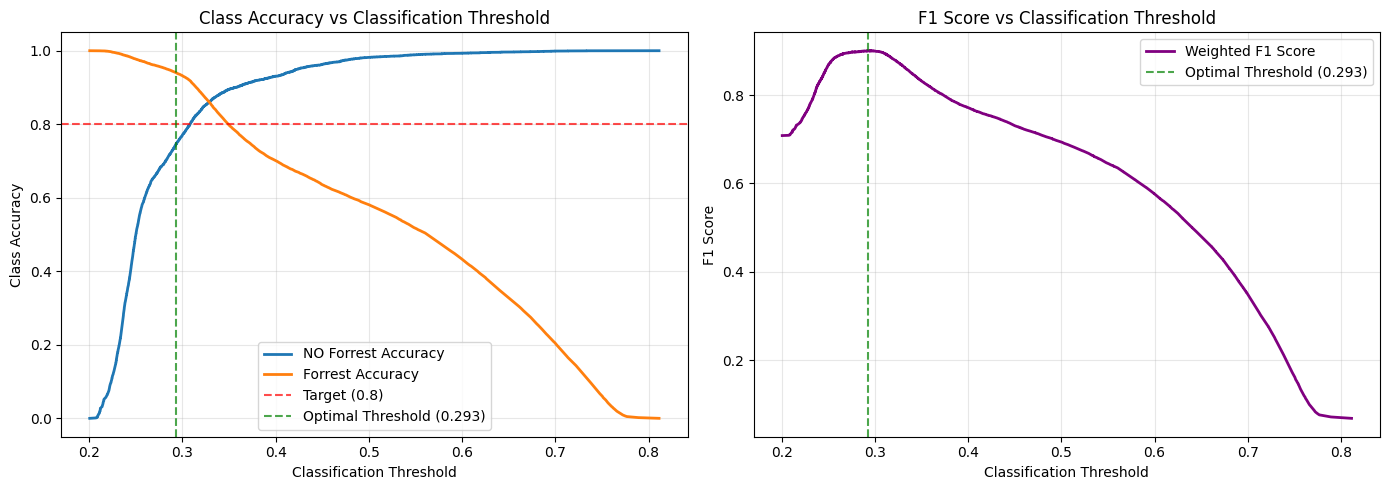


✅ Optimal threshold found: 0.293

🔧 Step 2: Creating new config with optimal threshold...
📊 New config hash: fc5c03f51b35c407c04a3a6af60bab2d
   Threshold: 0.293
   Using probabilities: True
   This ensures new predictions are saved separately!

🚀 Step 3: Training all plots with optimal threshold...
0:	learn: 0.8160954	test: 0.6938724	best: 0.6938724 (0)	total: 104ms	remaining: 3m 27s
100:	learn: 0.8419207	test: 0.7323690	best: 0.7326548 (97)	total: 10.6s	remaining: 3m 19s
200:	learn: 0.8471995	test: 0.7314527	best: 0.7330168 (117)	total: 21.3s	remaining: 3m 11s
300:	learn: 0.8516009	test: 0.7313178	best: 0.7330168 (117)	total: 32.2s	remaining: 3m 1s
400:	learn: 0.8560789	test: 0.7311554	best: 0.7330168 (117)	total: 43.1s	remaining: 2m 51s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7330167892
bestIteration = 117

Shrink model to first 118 iterations.
Trained model for plot: sample_1 (threshold: 0.293)
0:	learn: 0.8509918	test: 0.8059389	best: 0.8059389 (0)	to

In [27]:
# ============================================================================
# TRAIN WITH IMPROVED CONFIGURATION AND THRESHOLD OPTIMIZATION
# ============================================================================

# Step 1: Find optimal threshold on first plot
print("🔍 Step 1: Finding optimal threshold on first plot...")
test_plot_id = plot_ids[0]
ds_train_test, ds_val_test = load_dataset(ds_train, val_plot_id=test_plot_id)

# Create a temporary config for threshold finding (won't be used for final training)
config_temp = prepare_config(
    model_config_improved, 
    plot_ids, 
    {'sample_weight': True},
    use_proba=True,
    optimal_threshold=0.5  # Temporary, will find optimal
)

model_test, _, _, _, y_test_proba = train_with_proba(
    ds_train_test, ds_val_test, config=config_temp, plot_id=test_plot_id
)
optimal_threshold = plot_threshold_analysis(ds_val_test.y.values, y_test_proba)

print(f"\n✅ Optimal threshold found: {optimal_threshold:.3f}\n")

# Step 2: Create NEW config with optimal threshold (this will have a DIFFERENT hash!)
print("🔧 Step 2: Creating new config with optimal threshold...")
config_with_threshold = prepare_config(
    model_config_improved, 
    plot_ids, 
    {'sample_weight': True},
    use_proba=True,  # ⭐ This changes the hash
    optimal_threshold=optimal_threshold  # ⭐ This also changes the hash
)

print(f"📊 New config hash: {config_with_threshold['hash']}")
print(f"   Threshold: {config_with_threshold['optimal_threshold']:.3f}")
print(f"   Using probabilities: {config_with_threshold['use_proba']}")
print(f"   This ensures new predictions are saved separately!\n")

# Step 3: Train all plots with optimal threshold
print("🚀 Step 3: Training all plots with optimal threshold...")
train_leave_one_out(
    ds_train, 
    config_with_threshold,  # ⭐ Use the NEW config with threshold
    plot_ids, 
    use_proba=True, 
    optimal_threshold=optimal_threshold,
    force_retrain=False  # Set to True if you want to overwrite existing predictions
)

print("\n✅ Training complete! Use config_with_threshold to load predictions.")

📊 Loaded predictions from config hash: fc5c03f51b35c407c04a3a6af60bab2d
   Threshold used: 0.293
   Using probabilities: True



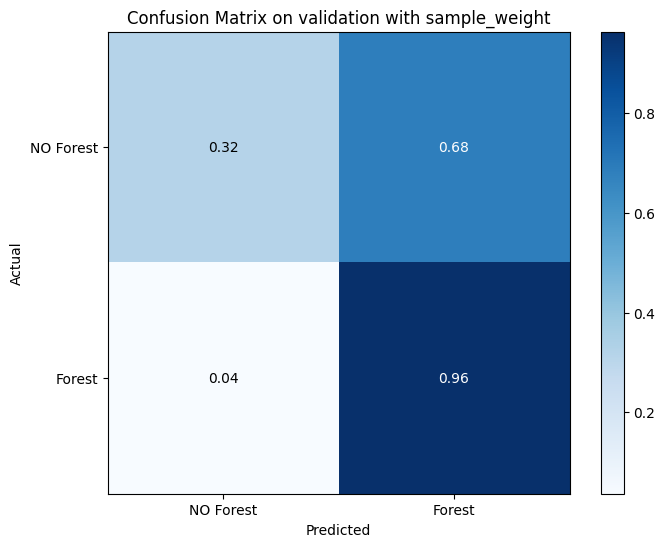

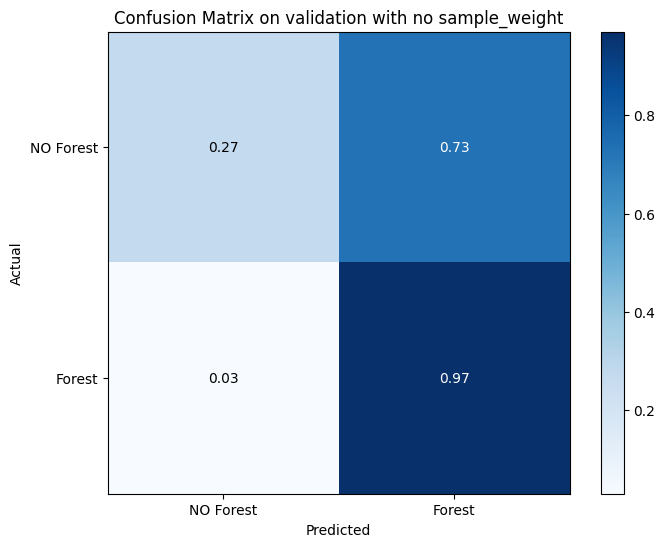


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   NO Forest       0.84      0.32      0.46 1.1343660683934063
      Forest       0.70      0.96      0.81 1.8656339316094521

    accuracy                           0.72 3.000000000002858
   macro avg       0.77      0.64      0.64 3.000000000002858
weighted avg       0.75      0.72      0.68 3.000000000002858



In [28]:
# ============================================================================
# LOAD AND EVALUATE PREDICTIONS WITH OPTIMIZED THRESHOLD
# ============================================================================

# Use the config with threshold (not the old config_improved)
# This loads predictions from the new hash
y_train_pred, y_train, y_test_pred, y_test, sample_weight_train, sample_weight_val = load_predictions(config_with_threshold)

print(f"📊 Loaded predictions from config hash: {config_with_threshold['hash']}")
print(f"   Threshold used: {config_with_threshold['optimal_threshold']:.3f}")
print(f"   Using probabilities: {config_with_threshold['use_proba']}\n")

# Plot confusion matrices
plot_confusion_matrix(y_test, y_test_pred, sample_weight=sample_weight_val, dataset="validation")
plot_confusion_matrix(y_test, y_test_pred, dataset="validation")

# Print detailed metrics
from sklearn.metrics import classification_report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_test_pred, 
                          target_names=['NO Forest', 'Forest'],
                          sample_weight=sample_weight_val))

In [ ]:
### Let's 